# Simple aperture photometry

* stack a few raw images
* subtract median
* find peaks and sort
* get n brightest peaks
* save centroid location (smaller box)
* crop image location and get new peak locations
* do photometry
* measure background
* measure fwhm

In [1]:
!python --version

Python 3.6.1 :: Continuum Analytics, Inc.


In [2]:
!conda env list

# conda environments:
#
astroconda               /home/Jerome/miniconda3/envs/astroconda
iraf27                   /home/Jerome/miniconda3/envs/iraf27
ircs_pol                 /home/Jerome/miniconda3/envs/ircs_pol
moscatel              *  /home/Jerome/miniconda3/envs/moscatel
py27                     /home/Jerome/miniconda3/envs/py27
root                     /home/Jerome/miniconda3



In [3]:
import os
from glob import glob
import getpass

filedir='/home/'+getpass.getuser()+'/data/transit/hatp44_data'
file_list = glob(os.path.join(filedir,'*.fits'))
file_list.sort()
len(file_list)

1456

get list of file per band 

In [4]:
from tqdm import tqdm
try:
    from astropy.io import fits as pf
except:
    import pyfits as pf

#suppose these come form config file
filters_in_config = 'g,r,z_s'.split(',')
bands = {}

for j in filters_in_config:
    #initialize dict with empty arrays
    j=j.strip(' ')
    bands[j]=[]
filters_in_hdr=[]
        
for i in tqdm(file_list):
    hdr = pf.getheader(i)
    filters_in_hdr.append(hdr['FILTER'])
    for j in filters_in_config:
        if hdr['FILTER'] == j:
            j=j.strip(' ')
            bands[j].append(i)

for key in bands.keys():
    print('{0}-band: {1} frames'.format(key, len(bands[key])))

100%|██████████| 1456/1456 [00:04<00:00, 336.05it/s]

g-band: 376 frames
r-band: 704 frames
z_s-band: 376 frames


## stack some raw images

In [5]:
import numpy as np

def stack_raw_image(image_list, skip_every=1):
    '''
    stack image using median to be used for detecting 
    source locations (i.e. target and ref stars)
    '''
    image_array = []
    for i in tqdm(image_list[::skip_every]):
        img = pf.getdata(i)
        image_array.append(img)
    stacked_image = np.median(image_array, axis=0)
    return stacked_image

In [6]:
stacked_images = []
for key in bands.keys():
    stacked_images.append(stack_raw_image(bands[key], skip_every=10))

100%|██████████| 38/38 [00:00<00:00, 145.52it/s]


In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

from astropy.visualization import ZScaleInterval

def show_stacked_images(images):
    fig, axes = plt.subplots(1,3,figsize=(15,5))
    titles='g,r,z'.split(',')
    for i,img in enumerate(images):
        vmin,vmax= ZScaleInterval().get_limits(img)
        axes[i].imshow(img,vmin=vmin,vmax=vmax)
        axes[i].set_title(titles[i])
    #return None

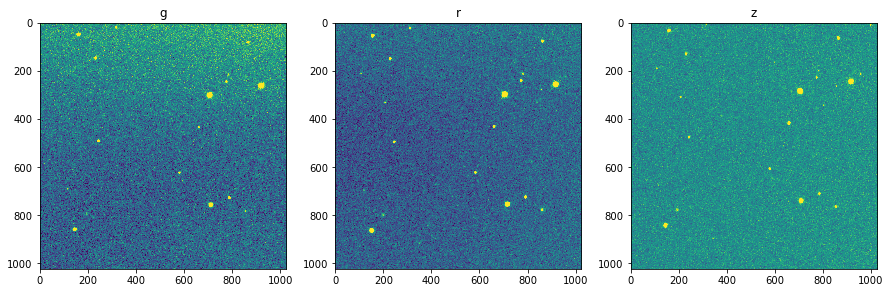

In [8]:
show_stacked_images(stacked_images)

In [ ]:
from photutils.detection import find_peaks
from astropy.stats import sigma_clipped_stats
from photutils import CircularAperture

def get_peaks(img, num_stars=10, box_size=10):
    '''
    Find local peaks in an image that are above above a specified
    threshold value.
    '''
    mean, median, std = sigma_clipped_stats(img, sigma=3.0, iters=5)
    threshold = median + (10.0 * std)
    tbl = find_peaks(img, threshold, box_size=box_size)
    #convert to pandas dataframe for easy sorting
    tbl = tbl.to_pandas()
    #sort by brightness
    tbl = tbl.sort_values(by='peak_value',ascending=False)
    return tbl.head(num_stars)

In [9]:
from photutils import DAOStarFinder
from astropy.stats import sigma_clipped_stats

def get_sources(img, num_stars=10, fwhm=8.0):
    mean, median, std = sigma_clipped_stats(img, sigma=3.0, iters=5)
    daofind = DAOStarFinder(fwhm=fwhm, threshold=5.*std)  
    sources = daofind(img - median)
    #convert to pandas dataframe for easy sorting
    sources = sources.to_pandas()
    #sort by brightness
    sources = sources.sort_values(by='peak',ascending=False)
    
    return sources.head(num_stars)

In [10]:
sources = []

for idx, img in enumerate(stacked_images):
    sources.append(get_sources(img, num_stars=20))

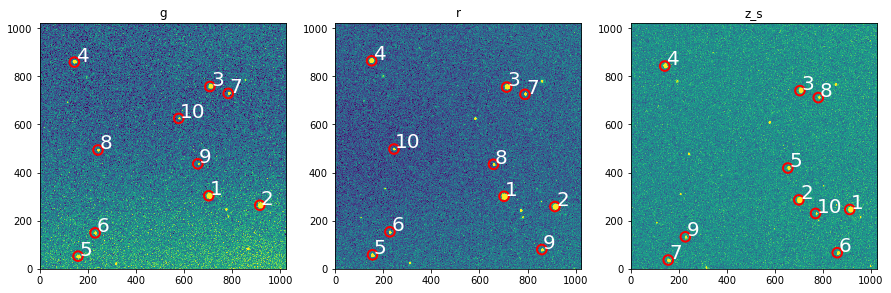

In [12]:
from photutils import CircularAperture
from astropy.visualization import ZScaleInterval
from photutils.detection import find_peaks
from astropy.stats import sigma_clipped_stats

def show_sources(image, sources, labels, method='sources', num_stars=10):
    '''
    similar to `show_peaks`; difference is `sources` used as input
    '''
    if isinstance(image, np.ndarray):
        if method == 'peaks':
            positions = (peaks['x_peak'].values[:num_stars], peaks['y_peak'].values[:num_stars])
        else: #default
            positions = (sources['xcentroid'].values[:num_stars], sources['ycentroid'].values[:num_stars])
        
        apertures = CircularAperture(positions, r=20.)
        vmin,vmax= ZScaleInterval().get_limits(image)
        plt.figure(figsize=(10,10))
        plt.imshow(image, origin='lower', vmin=vmin,vmax=vmax)
        for num, (x,y) in enumerate(zip(positions[0],positions[1])):
            plt.text(x+5,y+5, num+1, fontsize=20, color='w')
        apertures.plot(color='r', lw=2)
            
    elif len(image) == len(sources) and isinstance(image, list):
        fig, ax = plt.subplots(1,len(image),figsize=(15,5))
        for idx,(img,src) in enumerate(zip(image,sources)):
            positions = (src['xcentroid'].values[:num_stars], src['ycentroid'].values[:num_stars])
            apertures = CircularAperture(positions, r=20.)
            vmin,vmax= ZScaleInterval().get_limits(img)
            ax[idx].imshow(img, origin='lower', vmin=vmin,vmax=vmax)
            for num, (x,y) in enumerate(zip(positions[0],positions[1])):
                ax[idx].text(x+5,y+5, num+1, fontsize=20, color='w')
            apertures.plot(color='r', lw=2, ax=ax[idx])
        for idx, label in enumerate(labels):
            ax[idx].set_title(label)
    else:
        print('incorrect dimensions')
    
    #return None
    
show_sources(stacked_images, sources, list(bands.keys()), num_stars=10)

## aperture photometry

In [35]:
from photutils import CircularAperture
import numpy as np
from photutils import aperture_photometry

def get_phot(image, bkg_mean, centroid, aperture_radii):#, error):
    '''
    flux is measured by summing all the light within r and subtract the sky bkg mean.
    aperture_sum_err provides the propagated uncertainty associated with 'aperture_sum
    '''    
    apertures = [CircularAperture(centroid, r=r) for r in aperture_radii]
    
    err=0.01*image
    
    phot_table = aperture_photometry(image-bkg_mean, apertures, method='subpixel', error=err)
    #convert to pandas dataframe
    '''
    bug: Cannot convert a table with mixin columns to a pandas DataFrame
    '''
    #phot_table = phot_table.to_pandas()
    return phot_table

In [36]:
from photutils import CircularAnnulus

def get_bkg(image, centroid, r_in=10, r_out=20):
    '''
    To calculate the mean local background within the circular annulus aperture
    with thickness dr, divide its sum by its area calculated using the area() method
    '''
    annulus = CircularAnnulus(centroid, r_in, r_out)
    result = aperture_photometry(image, annulus)
    bkg_mean = float(result['aperture_sum'] / annulus.area())
    '''
    The background sum within the circular aperture is then the mean local background 
    times the circular aperture area
    
    bkg_sum = bkg_mean * apertures.area()
    residual=aperture_sum - bkg_sum
    '''
    return bkg_mean #, residual

In [37]:
def get_crop(image, centroid, box_size):
    x, y = centroid
    image_crop = np.copy(image[int(y-(box_size/2)):int(y+(box_size/2)),int(x-(box_size/2)):int(x+(box_size/2))])

    return image_crop

In [38]:
from photutils import centroid_com, centroid_1dg, centroid_2dg

def get_centroid(image, method='com'):
    '''
    centroid_com(): Calculates the object “center of mass” from 2D image moments.
    centroid_1dg(): Calculates the centroid by fitting 1D Gaussians to the marginal x and y distributions of the data.
    centroid_2dg(): Calculates the centroid by fitting a 2D Gaussian to the 2D distribution of the data.
    Default is centroid_2dg.
    ''' 
    if method=='com':
        x, y = centroid_com(image)
        return x,y
    
    elif method=='1d_gaussian':
        x, y = centroid_1dg(image)
        return x,y
    else: #default
        x, y = centroid_2dg(image)
        return x,y

In [39]:
def get_fwhm(image_crop):
    # https://python4astronomers.github.io/fitting/sherpa.html
    i,j = np.unravel_index(image_crop.argmax(), image_crop.shape) #take x,y max
    peak_x=image_crop[i,:]
    peak_y=image_crop[:,j]
    try:
        sigma=model_gaussian(peak_x, peak_y)
        fwhm=2.355*np.abs(sigma)
    except:
        #no good estimate
        fwhm=np.nan
        
    return fwhm

def gauss(x, *params):
    A, mu, sigma, eps= params
    return A*np.exp(-(x-mu)**2/(2.*sigma**2)) + eps

def model_gaussian(peak_x, peak_y,verbose=False):
    #estimate mean and standard deviation
    ydata = (peak_x+peak_y)/2.0
    xdata = np.array(range(len(ydata)))
    xmean = len(xdata)/2
    sigma = np.std(ydata)
    amp = np.max(ydata)
    eps =0.1
    #fitting
    popt, pcov = curve_fit(gauss, xdata, ydata, p0 = [amp, xmean, sigma, eps])

    #plt.plot(xdata,gauss(xdata, *popt), label='Gaussian fit')
    #plt.plot(xdata,ydata,'ok', label='data')
    #plt.legend()
    if verbose==True:
        print('A: {}\nmu: {}\nsigma= {}\neps: {}'.format(popt[0],popt[1], popt[2], popt[3]))
    return popt[2]

In [50]:
def make_lightcurve(band_list, star_positions, aperture_radii, skip_every=1, box_size=40):
    xcenters, ycenters = [], []
    tables = {}
    frames={}
    for star_idx, position in enumerate(star_positions):
        tables[star_idx]=[]
        print('performing aperture photometry on {} stars\n'.format(len(star_positions)))
        print('---------star index: {}---------'.format(star_idx))
        print('initial centroid: {}'.format(position))
        #each star position determined from the stacked image
        for i in tqdm(band_list[::skip_every]):
            #each image in a given band
            image = pf.getdata(i)
            hdr = pf.getheader(i)
            #crop
            img_crop = get_crop(image, position, box_size=box_size)
            #compute new centroid
            new_centroid = get_centroid(img_crop, method='com')
            #estimate background within annulus
            bkg= get_bkg(img_crop, new_centroid, r_in=rad+dr/2, r_out=rad+dr)
            #perform photometry
            phot_table = get_phot(img_crop, bkg, new_centroid, aperture_radii=aperture_radii)
            #add bkg
            phot_table['bkg'] = bkg
            #measure fwhm
            fwhm = get_fwhm(img_crop)
            phot_table['fwhm'] = fwhm
            #calculate centroid shift 
            xshift= phot_table['xcenter'].value - box_size/2.
            yshift= phot_table['ycenter'].value - box_size/2.
            #correct actual centroid (not cropped image)
            phot_table['xcenter'] = xshift+position[0]
            phot_table['ycenter'] = yshift+position[1]
            
            xcenters.append(phot_table['xcenter'])
            ycenters.append(phot_table['ycenter'])
            #add time
            phot_table['mjd'] = hdr['MJD-STRT']
            tables[star_idx].append(phot_table)
            #import pdb; pdb.set_trace()
    print('---------Done---------')
    return tables

In [51]:
import pandas as pd

def make_df(table):
    frames1, frames2, frames3 = [], [], []

    aperture_sum, error = {}, {}
    #for t in range(len(table[0])):
    for star in table.keys():
        time, bkg, fwhm = [],[],[]
        xcenter,ycenter=[],[]
        names1, names2 =[],[]
        #initialize          
        for r in aperture_radii:
            aperture_sum[r] = []
            error[r] = []
            names1.append('star{0}_flux_r{1}'.format(star,r))
            names2.append('star{0}_err_r{1}'.format(star,r))

        for t in table[star]:
            time.append(t['mjd'][0])
            xcenter.append(t['xcenter'][0])
            ycenter.append(t['ycenter'][0])
            bkg.append(t['bkg'][0])
            fwhm.append(t['fwhm'][0])

            for idx, r in enumerate(aperture_radii):
                aperture_sum[r].append(t['aperture_sum_'+str(idx)][0])
                error[r].append(t['aperture_sum_err_'+str(idx)][0])

        df1 = pd.DataFrame({'star{}_xcenter'.format(star): xcenter,
                            'star{}_ycenter'.format(star): ycenter,
                            'star{}_bkg'.format(star): bkg,
                            'star{}_fwhm'.format(star): fwhm},
                           index=time)
        frames1.append(df1)

        #column names to rename the original


        #df2 = pd.DataFrame({names1: aperture_sum, names2: error}, index=time)
        df2 = pd.DataFrame(aperture_sum, index=time)
        df2.columns = names1
        frames2.append(df2)

        df3 = pd.DataFrame(error, index=time)
        df3.columns = names2
        frames3.append(df3)

    params = pd.concat(frames1, axis=1)
    fluxes = pd.concat(frames2, axis=1)
    errors = pd.concat(frames3, axis=1)

    result = pd.concat([fluxes,errors,params], axis=1)
    return result

In [52]:
bands.keys()

dict_keys(['g', 'r', 'z_s'])

In [53]:
band_idx=2 #0:g; 1: r; 2:z
aperture_radii=np.arange(15,17,1)
top_brightest = 5
star_positions = list(zip(sources[band_idx]['xcentroid'].values, sources[band_idx]['ycentroid'].values))[:top_brightest]
skip_every=1
band_list=bands[list(bands.keys())[band_idx]]
#annulus
rad=max(aperture_radii)
dr=10 #thickness
    
table = make_lightcurve(band_list, star_positions, aperture_radii, skip_every)

  2%|▏         | 6/376 [00:00<00:06, 53.37it/s]

performing aperture photometry on 5 stars

---------star index: 0---------
initial centroid: (911.39188437197015, 246.12980190879145)


  2%|▏         | 6/376 [00:00<00:06, 56.93it/s]

performing aperture photometry on 5 stars

---------star index: 1---------
initial centroid: (699.53750528700039, 286.07443110839995)


  2%|▏         | 6/376 [00:00<00:06, 53.99it/s]

performing aperture photometry on 5 stars

---------star index: 2---------
initial centroid: (704.18187575311833, 740.5490320830886)


  2%|▏         | 6/376 [00:00<00:06, 57.30it/s]

performing aperture photometry on 5 stars

---------star index: 3---------
initial centroid: (141.80924549407234, 842.84580377023428)


  2%|▏         | 6/376 [00:00<00:06, 57.21it/s]

performing aperture photometry on 5 stars

---------star index: 4---------
initial centroid: (653.85638215459551, 418.63573919508372)


100%|██████████| 376/376 [00:06<00:00, 55.68it/s]

---------Done---------


In [54]:
result = make_df(table)
result.head()

,star0_flux_r15,star0_flux_r16,star1_flux_r15,star1_flux_r16,star2_flux_r15,star2_flux_r16,star3_flux_r15,star3_flux_r16,star4_flux_r15,star4_flux_r16,...,star2_xcenter,star2_ycenter,star3_bkg,star3_fwhm,star3_xcenter,star3_ycenter,star4_bkg,star4_fwhm,star4_xcenter,star4_ycenter
57799.596013,1.034115e+06,1.088588e+06,1.101803e+06,1.157251e+06,684004.784897,737423.489800,545787.054313,598337.064891,429104.904270,481230.248523,...,703.549476,739.900309,236.055633,NaN,141.292064,842.261775,236.026538,NaN,653.350004,418.112866
57799.596753,1.030766e+06,1.084850e+06,1.096109e+06,1.150846e+06,679507.469019,731651.465181,539801.807896,591783.136938,426059.436069,477738.351670,...,703.625063,739.835926,232.432174,NaN,141.416087,842.224261,233.874136,NaN,653.364480,418.096583
57799.597494,1.028948e+06,1.083149e+06,1.093090e+06,1.147625e+06,677573.384492,729937.297017,538851.675049,590676.564170,424909.789072,475922.933784,...,703.465666,740.015749,233.787409,NaN,141.290332,842.323049,234.058953,NaN,653.337725,418.134045
57799.598235,1.023372e+06,1.078262e+06,1.088633e+06,1.143817e+06,677199.064985,729593.193457,538880.915596,590475.098555,425611.596006,476688.385117,...,703.423565,739.861996,232.998610,NaN,141.273468,842.230349,231.729730,NaN,653.350218,418.096622
57799.598964,1.034820e+06,1.089021e+06,1.095522e+06,1.149703e+06,678726.099907,731157.981758,537092.160037,588644.214822,422578.656235,473337.337944,...,703.613007,739.895366,231.663980,NaN,141.400911,842.225278,231.475691,NaN,653.379154,418.084811


In [55]:
aperture_radii

array([15, 16])

get columns with specific radius

In [56]:
df_cols = {}
for r in aperture_radii:
    df_cols[r] = []
    for i in result.columns:
        if i.split(',')[0].split('_')[-1]=='r'+str(r):
            df_cols[r].append(i)

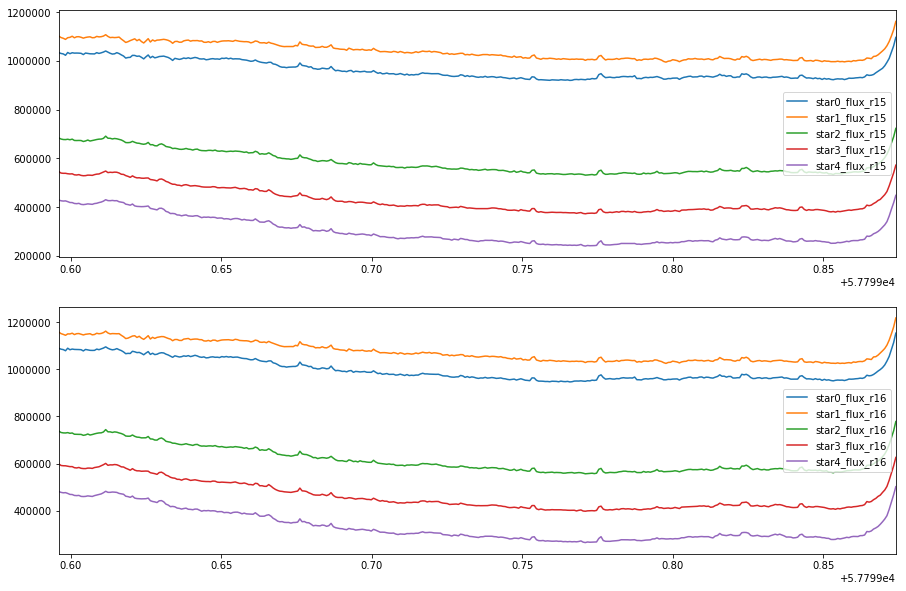

In [57]:
fig, ax = plt.subplots(len(aperture_radii),1,figsize=(15,10))

for idx, r in enumerate(df_cols.keys()):
    result[df_cols[r][:len(star_positions)]].plot(ax=ax[idx])

background

## Relative photometry: one aperture

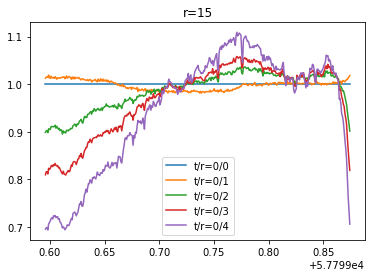

In [59]:
r=15
target_id = 0

target = result[df_cols[r][target_id]]

for ref_id, star_col in enumerate(df_cols[r][:len(star_positions)]):
    #loop all ref_ids
    ref = result[star_col]
    f = (target/ref).values
    f /= np.median(f)
    t = target.index.values
    plt.title('r={}'.format(r))
    plt.plot(t,f,label='t/r={0}/{1}'.format(target_id, ref_id))
plt.legend()

## Relative photometry: multiple apertures

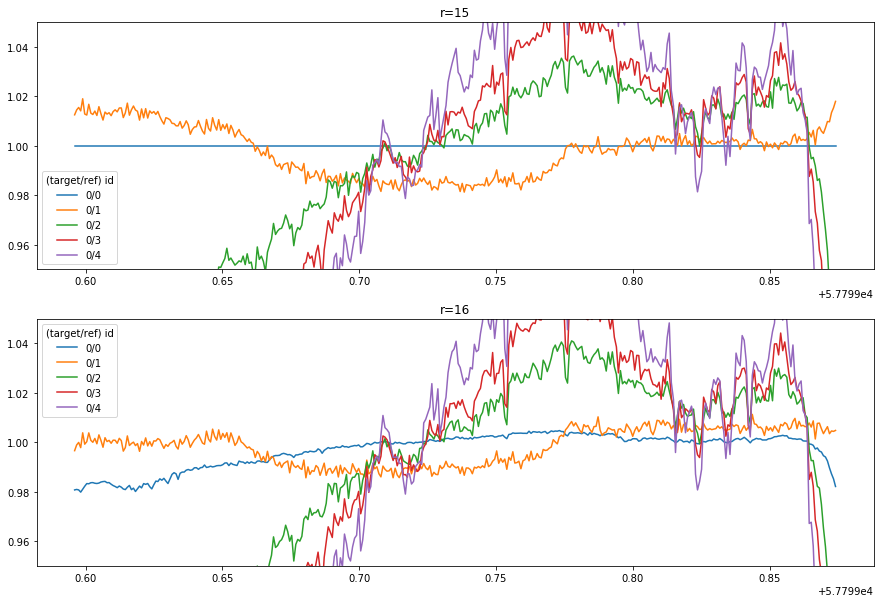

In [60]:
target_id = 0

target = result[df_cols[r][target_id]]
fig, ax = plt.subplots(len(aperture_radii),1,figsize=(15,10))

for idx, r in enumerate(df_cols.keys()):
    for ref_id, star_col in enumerate(df_cols[r][:len(star_positions)]):
        #loop all ref_ids
        ref = result[star_col]
        f = (target/ref).values
        f /= np.median(f)
        t = target.index.values
        ax[idx].set_title('r={}'.format(r))
        ax[idx].plot(t,f,label='{0}/{1}'.format(target_id, ref_id))
        ax[idx].legend(title='(target/ref) id')
        ax[idx].set_ylim([0.95,1.05])

## Selected target & ref

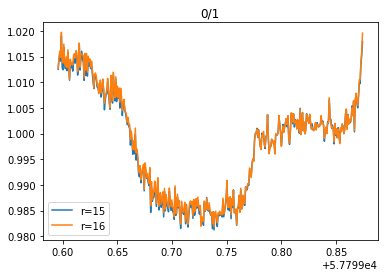

In [61]:
target_id = 0
ref_id = 1

clip = (10,10)
for idx, r in enumerate(df_cols.keys()):
    target = result[df_cols[r][target_id]]
    ref = result[df_cols[r][ref_id]]
    f = (target/ref).values
    f /= np.median(f)
    t = target.index.values
    plt.title('{0}/{1}'.format(target_id, ref_id))
    plt.plot(t,f,label='r={}'.format(r))
    plt.legend()